In [31]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Chemins vers les dossiers contenant les images
data_dir = 'Brain-Tumor-Classification-DataSet-master/Training/'

# Paramètres
img_height, img_width = 256, 256
batch_size = 32

# Utilisation de ImageDataGenerator pour la génération des données avec augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

# Générateur de données d'entraînement
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(256, 256),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    subset='training'
)

# Générateur de données de validation
validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(256, 256),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    subset='validation'
)
#categorical
#binary

Found 2585 images belonging to 4 classes.
Found 285 images belonging to 4 classes.


In [32]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy

def unet_model(input_size=(256, 256, 3), num_classes=4):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(conv4)
    
    # Decoder
    up5 = UpSampling2D(size=(2, 2))(conv4)
    merge5 = Concatenate()([conv3, up5])
    conv5 = Conv2D(128, 3, activation='relu', padding='same')(merge5)
    conv5 = Conv2D(128, 3, activation='relu', padding='same')(conv5)
    
    up6 = UpSampling2D(size=(2, 2))(conv5)
    merge6 = Concatenate()([conv2, up6])
    conv6 = Conv2D(64, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(64, 3, activation='relu', padding='same')(conv6)
    
    up7 = UpSampling2D(size=(2, 2))(conv6)
    merge7 = Concatenate()([conv1, up7])
    conv7 = Conv2D(32, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(32, 3, activation='relu', padding='same')(conv7)
    
    flatten = Flatten()(conv7)
    dense1 = Dense(128, activation='relu')(flatten)
    dense2 = Dense(num_classes, activation='softmax')(dense1)
    
    model = Model(inputs, dense2)
    
    model.compile(optimizer=Adam(lr=1e-4), loss=CategoricalCrossentropy(), metrics=[Accuracy()])
    
    return model

# Création du modèle
model = unet_model(input_size=(256, 256, 3), num_classes=4)

# Afficher le résumé du modèle
model.summary()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_56 (Conv2D)          (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_57 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_58 (Conv2D)          (None, 64, 64, 128)       7385

In [40]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Remplacer l'entrée par une image en noir et blanc
input_layer = Input(shape=(256, 256, 1))
x = tf.image.grayscale_to_rgb(input_layer)
x = base_model(x, training=False)

x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=predictions)

# Compilation du modèle
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



In [42]:
# Entraîner le modèle
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)


Epoch 1/10
81/81 [==============================] - 237s 3s/step - loss: 0.5626 - accuracy: 0.7500 - val_loss: 0.5624 - val_accuracy: 0.7500
Epoch 2/10
81/81 [==============================] - 3467s 43s/step - loss: 0.5626 - accuracy: 0.7500 - val_loss: 0.5624 - val_accuracy: 0.7500
Epoch 3/10
81/81 [==============================] - 673s 8s/step - loss: 0.5626 - accuracy: 0.7500 - val_loss: 0.5623 - val_accuracy: 0.7500
Epoch 4/10
81/81 [==============================] - 220s 3s/step - loss: 0.5625 - accuracy: 0.7500 - val_loss: 0.5623 - val_accuracy: 0.7500
Epoch 5/10
81/81 [==============================] - 231s 3s/step - loss: 0.5625 - accuracy: 0.7500 - val_loss: 0.5623 - val_accuracy: 0.7500
Epoch 6/10
81/81 [==============================] - 227s 3s/step - loss: 0.5625 - accuracy: 0.7500 - val_loss: 0.5623 - val_accuracy: 0.7500
Epoch 7/10
81/81 [==============================] - 5513s 69s/step - loss: 0.5625 - accuracy: 0.7500 - val_loss: 0.5623 - val_accuracy: 0.7500
Epoch 8/1

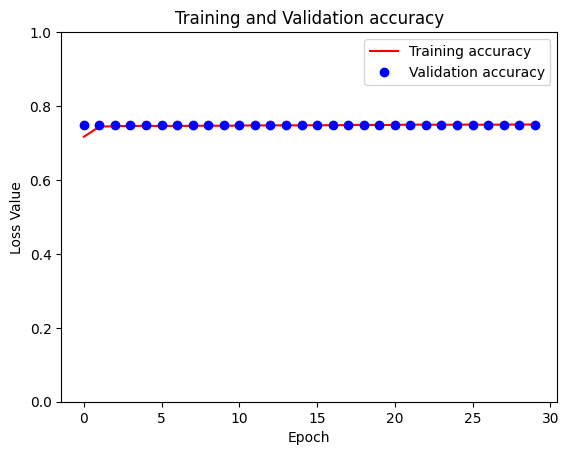

In [ ]:
import matplotlib.pyplot as plt
accuracy = model.history.history['accuracy']
val_accuracy = model.history.history['val_accuracy']

plt.figure()
plt.plot( accuracy, 'r', label='Training accuracy')
plt.plot( val_accuracy, 'bo', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
import os
from tensorflow.keras.preprocessing import image
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix

# Liste des classes
class_names = ['no_tumor', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']

def predict_image(image_path):
    img = image.load_img(image_path, target_size=(256, 256), color_mode='grayscale')
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)  # Prédiction multi-classes
    return class_names[predicted_class[0]]

def evaluate_on_test_set(test_dir):
    y_true = []
    y_pred = []

    for class_name in class_names:
        class_dir = os.path.join(test_dir, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            predicted_label = predict_image(img_path)
            true_label = class_name
            y_true.append(true_label)
            y_pred.append(predicted_label)
            print(f"Image: {img_name} - Predicted: {predicted_label} - True: {true_label}")

    # Calcul de l'accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Calcul de la sensibilité (rappel)
    sensitivity = recall_score(y_true, y_pred, average='macro')

    # Calcul de la spécificité
    cm = confusion_matrix(y_true, y_pred, labels=class_names)
    specificity = []
    for i in range(len(class_names)):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity.append(tn / (tn + fp))
    specificity = np.mean(specificity)

    print(f"Accuracy: {accuracy}")
    print(f"Sensitivity (Recall): {sensitivity}")
    print(f"Specificity: {specificity}")

# Exécuter l'évaluation sur le dossier de test
test_dir = 'Brain-Tumor-Classification-DataSet-master/Testing'
evaluate_on_test_set(test_dir)


1/1 [==============================] - 0s 42ms/step
Image: image(49).jpg - Predicted: no_tumor - True: no_tumor
1/1 [==============================] - 0s 41ms/step
Image: image(1).jpg - Predicted: no_tumor - True: no_tumor
1/1 [==============================] - 0s 42ms/step
Image: image(103).jpg - Predicted: no_tumor - True: no_tumor
1/1 [==============================] - 0s 42ms/step
Image: image(73).jpg - Predicted: no_tumor - True: no_tumor
1/1 [==============================] - 0s 44ms/step
Image: image(24).jpg - Predicted: no_tumor - True: no_tumor
1/1 [==============================] - 0s 42ms/step
Image: image(32).jpg - Predicted: no_tumor - True: no_tumor
1/1 [==============================] - 0s 40ms/step
Image: image(65).jpg - Predicted: no_tumor - True: no_tumor
1/1 [==============================] - 0s 60ms/step
Image: image(12).jpg - Predicted: no_tumor - True: no_tumor
1/1 [==============================] - 0s 40ms/step
Image: image(45).jpg - Predicted: no_tumor - True: n